# Get Embedding for Each Tile From the A Prediction Layer of the SSL Model

After the SSL (SWAV) model is trained. Each tile is passed through the SSL model and a feature embedding of size 256 is extracted from the projector (3rd layer of the projector). These embeddings together with the files names are saved in a pickle file.  


In [1]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.data.all import *
import numpy as np
import matplotlib.pyplot as plt
from self_supervised.augmentations import *
from self_supervised.layers import *
from skimage import io
import torch

In [2]:
# a read function for the tif images 
def open_img(pth, chnls=None, cls=torch.Tensor):
    file = rasterio.open(pth)
    r, g, b, = file.read(1), file.read(2), file.read(3)
    img = np.stack([r,g,b], axis=2)
    im = torch.from_numpy(img).type(torch.float32)
    if chnls is not None: 
        im = im[...,chnls]
    return cls(im)

# a custom class to store the tile images and pass them to the DataBlock object
class MCTensorImage(TensorImage):
    
    def __init__(self, x, chnls=None, chnls_first=False):
        self.chnls = chnls

    @classmethod
    def create(cls, data:(str,ndarray), chnls=None, chnls_first=False):
        
        if  isinstance(data, str):
            if str(data).endswith('jpg'): im = open_img(pth=data, chnls=chnls, cls=torch.Tensor)

        elif isinstance(data, ndarray): 
            im = torch.from_numpy(data)
        else:
            im = data

        # normalize pixel values to the range [0,1]
        im = torch.div(im, 255)
        
        return cls(im, chnls_first=chnls_first)

    # a function to show different channels of the tiles
    def show(self, chnls=[0,1,2], bright=1., ctx=None, title=None):
        
        if img.ndim > 2:
            if chnls is not None:
                visu_img = self[..., chnls]
        else:
            visu_img = self
        
        visu_img *= bright
        visu_img = np.where(visu_img > 1, 1, visu_img)
        visu_img = np.where(visu_img < 0, 0, visu_img)
        
        if ctx is None:
            plt.imshow(visu_img) 
            if title is not None:
                plt.title.set_text(title)
                plt.axis('off')
        else:
            ctx.imshow(visu_img)
            if title is not None:
                ctx.title.set_text(title)
                ctx.axis('off')
        
        return ctx
    
    def __repr__(self):
        
        return (f'MCTensorImage: {self.shape}')

In [3]:
import albumentations as A 

# a custom transformation function for input images of type MCTensorImage 
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: MCTensorImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        aug_img *= 255
        aug_img = aug_img.astype('uint8')
        aug_img = PILImage.create(aug_img)
        return aug_img

size=112 # image size    
# transformation functions for the training dataset
def get_train_aug(): return A.Compose([
                      A.VerticalFlip(),
                      A.ShiftScaleRotate(p=.9),
                      A.HorizontalFlip(),
                      A.CoarseDropout(max_holes=5, max_height=5, max_width=5, fill_value=0),
                      A.Resize(size,size)
        ])

# transformation functions for the validation dataset
def get_valid_aug(): return A.Compose([
                      A.VerticalFlip(),
                      A.ShiftScaleRotate(p=.9),
                      A.HorizontalFlip(),
                      A.CoarseDropout(max_holes=5, max_height=5, max_width=5, fill_value=0),
                      A.Resize(size,size)
        ])

In [4]:
def get_y(x):
    return 1

# this function creates a DataLoader for the tile images
def create_dls(df, size=224, col_splitter=False, bs=128):
    
    # split the dataset into training and validation
    if col_splitter:
        splitter = ColSplitter("is_valid")
    else:
        splitter = RandomSplitter(valid_pct=0.1, seed=36)
    
    item_tfms =  [AlbumentationsTransform(get_train_aug(), get_valid_aug())]
    batch_tfms = [IntToFloatTensor]
    
    # create a datablock
    rocks = DataBlock(
                blocks = (TransformBlock(type_tfms=partial(MCTensorImage.create, chnls_first=False)), CategoryBlock),
                get_x = ColReader('path'),
                splitter = splitter,
                get_y = partial(get_y),
                item_tfms = item_tfms,
                batch_tfms = batch_tfms
            )
    
    # generate the dataloader
    dls = rocks.dataloaders(df,bs=bs, shuffle=False, drop_last=True)
    return dls


In [5]:
import pandas as pd

# read the csv file containing location of the tile images
csv_file_path = f"../data/processed/all_tiles.csv"
df_train = pd.read_csv(csv_file_path)
df_train['label'] = 1
df_train.head()
print(df_train.shape)

(66769, 3)


/home/ubuntu/miniconda3/envs/fastai/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


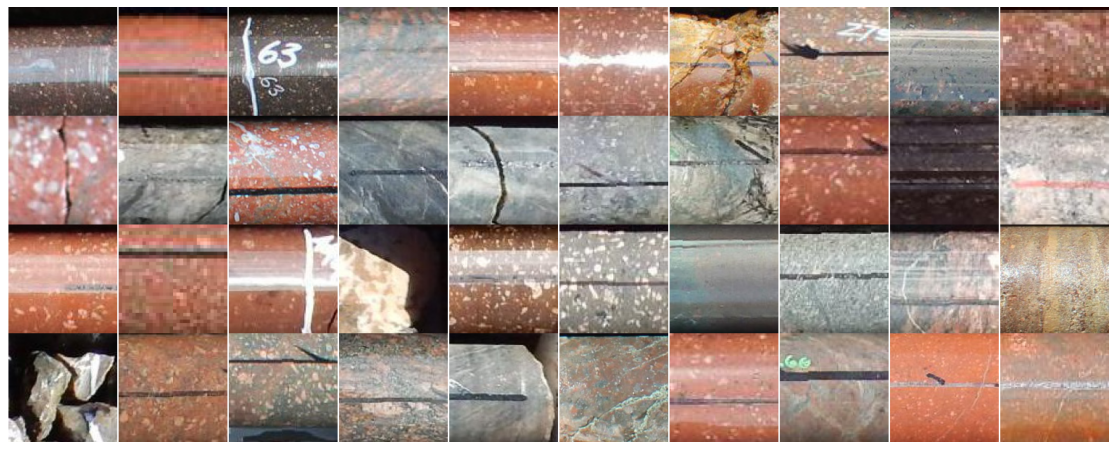

In [6]:
import cv2
import rasterio

def show_grid_imgs(fnames, size=150, fig_base_size=2, n_cols=10, save_path=None):

    # get number of rows 
    n_rows = len(fnames)//n_cols
    if len(fnames) > 0:
        imgs = [] # list row of squares
        for i in range(n_rows + 1):
            if i*n_cols == len(fnames):
                break
            # get the list of filenames that will be shown in one row
            fns = fnames[i*n_cols:(i+1)*n_cols]
            file = rasterio.open(fns[0])
            r, g, b, = file.read(1), file.read(2), file.read(3)
            img = np.stack([r,g,b], axis=2)
            img = cv2.resize(img,(size,size), interpolation=cv2.INTER_AREA)
            size = img.shape[0]
            if len(fns) > n_cols:
                list_imgs = []
                for fn in fns[:n_cols]:
                    file = rasterio.open(fn)
                    r, g, b, = file.read(1), file.read(2), file.read(3)
                    img = np.stack([r,g,b], axis=2)
                    list_imgs.append(np.hstack([np.full(shape=(size,2,3),fill_value=255,dtype=int),
                    np.array(cv2.resize(img,(size,size), interpolation=cv2.INTER_AREA))]))
            else:
                list_imgs = []
                for fn in fns[:]:
                    file = rasterio.open(fn)
                    r, g, b, = file.read(1), file.read(2), file.read(3)
                    img = np.stack([r,g,b], axis=2)
                    list_imgs.append(np.hstack([np.full(shape=(size,2,3),fill_value=255,dtype=int),
                    np.array(cv2.resize(img,(size,size), interpolation=cv2.INTER_AREA))]))
                list_imgs += [np.hstack([np.full(shape=(size,2,3),fill_value=255,dtype=int),
                np.full(shape=(size,size,3),fill_value=255,dtype=int)]) for i in range(n_cols-len(fns))]
            # concatenate the images in one row
            img = np.hstack(list_imgs)
            imgs += [img]
        if len(imgs) != 0 :
            img = PILImage.create(np.array(np.vstack(imgs),dtype=np.uint8))
            # save or show the images
            if save_path != None: img.save(save_path)
            else: img.show(figsize=(fig_base_size*n_cols,fig_base_size*n_rows))
            
bs=128
# define dataloaders
dls = create_dls(df_train, col_splitter=False,bs=bs)
show_grid_imgs(dls[0].items.path.values[:40], n_cols=10);

In [7]:
seed = 123 #123
set_seed(seed) # set random seed
project_name = 'diavik' 
encoder_name = "resnet50" # define encoder architecture eg. xresnet34
algorithm = "SWAV"
hidden_size = 256 # size of the layer before feature layer
projection_size = 256 # feature size
lr,wd,epochs=1e-4,1e-3,300 # initializing hyperparameter values
model_name = f"{project_name}_{encoder_name}_{algorithm}_{hidden_size}hs_{projection_size}ps"
model_name += f"_{bs}bs_{lr}lr_{epochs}epochs_{seed}seed_best"
model_dir = f"../outputs/" # directory where the trained model will be saved
model_name # name of the stored model files

'diavik_resnet50_SWAV_256hs_256ps_128bs_0.0001lr_300epochs_123seed_best'

In [8]:
from self_supervised.vision.swav import *

# define the encoder architecture
encoder = create_encoder(encoder_name, n_in=3, pretrained=False) # a fastai encoder
#encoder = create_encoder("tf_efficientnet_b4_ns", n_in=3, pretrained=False) # a timm encoder

# create an instance of SWAV model with the defined encoder
model = create_swav_model(encoder, hidden_size=hidden_size, projection_size=projection_size)

# define the transformations for the SWAV model
aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
                                       crop_sizes=[size,int(3/4*size)], 
                                       min_scales=[0.25,0.2],
                                       max_scales=[1.0,0.35],
                                       rotate=True, rotate_deg=10, jitter=False, bw=False, blur=False) 

cbs=[SWAV(aug_pipelines=aug_pipelines, crop_assgn_ids=[0,1], K=bs*2**6, queue_start_pct=0.5, temp=0.1)]

# generate a learner object with the defined dataloader, SWAV model and augmentation pipeline
learn = Learner(dls, model, cbs=cbs, model_dir=model_dir)

In [9]:
def get_output(module, input_value, output):
    return output.flatten(1)

def get_named_module_from_model(model, name):
    for n, m in model.named_modules():
        if n == name:
            return m
    return None

class Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m:nn.Module, hook_func, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input, output):
        "Applies `hook_func` to `module`, `input`, `output`."
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
        

# load the trained SWAV model
saved_learn = learn.load(model_name)
model = saved_learn.model
model.cuda()   

# define the layer from which embeddings will be extracted
linear_output_layer = get_named_module_from_model(model, "projector.3")

import time
img_repr_map = {}
start_time = time.time()
print("Generating feature map ...")
total = 0
with Hook(linear_output_layer, get_output, True, True) as hook:
    start = time.time()
    for i, (xb, yb) in enumerate(dls[0]):
        cur_bs = xb.shape[0]
        end = i*bs + cur_bs
        img_ids = dls[0].items[i*bs:end].path.values
        result = model.eval()(xb)
        img_reprs = hook.stored.cpu().numpy()
        img_reprs = img_reprs.reshape(cur_bs, -1)
        #print(img_reprs)
        for j in range(cur_bs):
            img_repr_map[img_ids[j]] = img_reprs[j]
        if(len(img_repr_map) % 12800 == 0):
            end = time.time()
            print(f'{end-start} secs for 12800 images')
            start = end
            
# save the embeddings for all tiles in a datafram object
print("Total processing time: ", time.time()-start_time)
img_repr_df = pd.DataFrame(img_repr_map.items(), columns=['path', 'feature'])

img_repr_df

Generating feature map ...
17.275182723999023 secs for 12800 images
17.002634525299072 secs for 12800 images
16.925496339797974 secs for 12800 images
16.540545225143433 secs for 12800 images
Total processing time:  79.06815838813782


,path,feature
0,../data/processed/coherent_tiles/MSDP07_33+34_87.07_87.93-box-0-row-0_3.jpg,"[0.5181697, 0.89414716, -0.825712, 1.1336331, -2.1630812, -0.67438525, 0.9908441, 0.6649723, -1.6331211, -1.627225, -1.7332015, 0.1902571, -0.14574914, 1.707001, 0.2296686, -1.5913322, 0.99739474, 1.5888368, 1.1817192, -2.2596197, -0.3907094, 1.0494004, -2.0169663, -0.28947365, -2.3668804, 1.899537, 0.2602474, 1.3890187, 1.7662338, -0.44784638, -1.0113587, -0.36278248, 0.27035663, -1.7146194, 1.3947043, -2.7422757, 0.89144343, -1.815395, 1.8593965, 0.86535186, -0.99950635, -1.0191518, -0.150208, 0.21110068, 0.53142285, -0.603291, 1.0156306, -0.37613901, -2.4050684, 0.1603174, -0.6461636, 0..."
1,../data/processed/coherent_tiles/MSDP05_97+98_309.55_310.34-box-1-row-0_5.jpg,"[1.3738123, -0.06213107, 0.1130183, 0.12650858, -0.5217766, 0.18033919, 0.15520994, 0.97359526, -0.0039975788, -0.7885077, 0.043970753, -0.07996082, -1.961648, 0.5282489, 0.7440475, -1.8249229, 0.81995475, 2.3963459, 0.27657267, -0.58646846, 0.5541819, 1.2143791, -0.38005075, 0.67393196, -1.1320642, -0.4466002, -0.016371131, 1.0808547, 1.0934446, -0.41542658, -1.3631432, -0.65011317, -0.787864, -2.4368412, 0.25491005, -1.4365785, 1.384105, -1.4168245, 0.7028077, -0.40843457, -0.6022198, -0.4794987, -0.7400966, -0.6330981, -0.1951279, 0.8278066, 0.7427592, 1.0809743, -1.3824486, 1.0770278, ..."
2,../data/processed/coherent_tiles/MSDP07_25+26_62.85_63.59-box-0-row-3_6.jpg,"[0.25196564, 1.0562482, -0.700365, 1.246938, -2.138652, -0.889735, 0.9704559, 0.5846462, -1.5196323, -1.7256246, -1.9937208, 0.29831764, 0.103977636, 1.7662138, 0.04744583, -1.3196559, 1.1817396, 1.6445165, 1.0187308, -2.332834, -0.27128223, 1.074301, -1.9884331, -0.6397152, -2.3986592, 1.9657696, 0.28909427, 1.2740575, 2.0512986, -0.33563307, -0.76361954, -0.3408455, 0.2964092, -1.3765466, 1.3038852, -3.084866, 0.6597271, -1.5726987, 1.8721458, 0.6121052, -1.0460455, -0.7603801, -0.15041038, 0.26758784, 0.61212456, -0.47295424, 0.75647074, -0.77731675, -2.3933048, 0.04558724, -0.7039113, ..."
3,../data/processed/coherent_tiles/MSDP12_61+62_162.88_163.7-box-0-row-4_20.jpg,"[0.8619063, 0.5281307, -0.543004, 0.9236792, -1.4048319, 0.05287346, 0.9351327, 0.6512553, -0.509949, -0.90456516, -0.7889579, -0.034150712, 0.05385161, 1.2810788, -0.0598471, -1.841588, 0.6066137, 1.1725202, 0.62701756, -1.3315014, 0.4434038, 0.10742051, -1.7965895, 0.20852703, -1.5052191, 0.8990467, 0.328374, 1.252662, 1.7128818, -0.3508927, -0.45849597, -0.61921364, -0.87335813, -1.3069752, 1.4278874, -2.0353441, 0.633485, -1.1072536, 1.1838709, 0.7644459, 0.047798064, -1.0605308, 0.041821584, 0.17606542, -0.2639889, 0.4333237, 0.8723006, 0.07650739, -1.8389081, 0.7182274, -0.6472493, 0..."
4,../data/processed/coherent_tiles/MSDP07_134+135_475.55_476.44-box-0-row-4_14.jpg,"[1.4049928, 0.5196565, 0.03127447, 0.89462805, -0.9116339, -0.15789144, 0.9146411, 0.94134897, 0.03120412, -1.073658, -0.6727649, -0.09241368, -1.329529, 0.46110472, 0.33630812, -1.9306766, 0.483841, 2.2690299, 0.5841269, -0.971679, 0.55544424, 0.92028886, -1.3643069, 0.16420923, -1.8080038, 0.41061804, 0.24303319, 0.9983524, 1.4242646, -0.6037837, -0.85885143, -0.41017404, -0.87846893, -1.899659, 1.2529635, -2.2539256, 1.1584177, -1.2714782, 1.071289, 0.35145947, -0.45201004, -0.86353576, -0.8916525, -0.5795477, -0.07599184, 0.24275821, 0.9111734, 0.14958468, -1.5671355, 0.97925574, -1.38..."
...,...,...
60027,../data/processed/coherent_tiles/MSDP05_139+140_480.58_481.42-box-0-row-0_10.jpg,"[0.784637, 0.69640523, -0.20145646, 0.53208447, -1.8128197, -0.09113343, 0.82938963, 0.4236575, -1.5748777, -1.2170377, -1.7046566, 0.6174787, -0.63638717, 1.764634, -0.14466581, -1.2746809, 1.2496414, 2.1175165, 0.7231854, -1.6001742, -0.015160921, 0.9744706, -1.3836081, -0.31628862, -2.0691888, 1.5808625, 0.61325866, 1.4667195, 1.8824794, -0.40058145, -1.2813889, -0.18677242, 0.01626652, -1.6709795, 0.7386655, -2.4821484, 0.7737382, -1.5331028, 1.5392992, 0.27723414, -0.

In [10]:
# Save the dataframe as a pickle file
df = img_repr_df
df['filename'] = img_repr_df.path.apply(lambda x: Path(x).name)
df.to_pickle(f"../outputs/features.pkl")